## **Cross validation for the icesat, icesat-2, cryosat-2 and aster dem data**

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from utils.imgShow import imgShow
from utils.crop2extent import img2extent
import pandas as pd
from utils.transform_xy import geo2imagexy
from utils.geotif_io import readTiff
from glob import glob
import random
import os
from scipy.stats import norm
import pickle



### Get land cover (glacier/stable region), aster dem value of the altimeter footprint.

In [2]:
def altimeter_dem_cross(path_altimeter, path_aster_dem, path_srtm_dem, path_stable, path_glacier):
    ## 1. read in data.
    ### 1.1 read in image
    aster_dem, aster_dem_info = readTiff(path_aster_dem)

    ### srtm dem
    srtm_dem = img2extent(path_img=path_srtm_dem, extent=aster_dem_info['geoextent'], size_target = aster_dem.shape) # read and resize
    ### Stable mask
    mask_stable = img2extent(path_img=path_stable, extent=aster_dem_info['geoextent'], size_target = aster_dem.shape) # read and resize
    ### Glacier masks
    mask_glacier = img2extent(path_img=path_glacier, extent=aster_dem_info['geoextent'], size_target = aster_dem.shape) # read and resize
    ### 1.2 read in icesat-1 data.
    alt_dem_dict = {}
    with h5py.File(path_altimeter, 'r') as f_read:
        for key in f_read.keys(): alt_dem_dict[key] = f_read[key][:]

    ## - 2. Remove the icesat data outside the extent of dem.
    ids_in_extent = np.where((alt_dem_dict['lon']>aster_dem_info['geoextent'][0]) & (alt_dem_dict['lon']<aster_dem_info['geoextent'][1]) & \
                                    (alt_dem_dict['lat']>aster_dem_info['geoextent'][2]) & (alt_dem_dict['lat']<aster_dem_info['geoextent'][3]))[0]
    for key in alt_dem_dict: alt_dem_dict[key] = alt_dem_dict[key][ids_in_extent]   ## update the icesat data
    row_fp_dem, col_fp_dem = geo2imagexy(x=alt_dem_dict['lon'], y=alt_dem_dict['lat'], \
                                                gdal_trans=aster_dem_info['geotrans'], integer=True) 

    ## 3. get new values: aster dem value, land cover type (glacier/region), and srtm dem
    dem_fp = aster_dem[row_fp_dem, col_fp_dem]
    alt_dem_dict['dem_fp'] = dem_fp
    ### Assign footprint type:  stable (1), glacier (2).
    alt_dem_dict['type_fp'] = np.zeros_like(alt_dem_dict['lon'])  ## stable type: 0
    
    ids_stable = np.where(mask_stable[row_fp_dem, col_fp_dem]==1)[0]     ### Stable land cover type
    alt_dem_dict['type_fp'][ids_stable]=1
    ids_glacier = np.where(mask_glacier[row_fp_dem, col_fp_dem]==1)[0]   ### Glacier land cover type
    alt_dem_dict['type_fp'][ids_glacier]=2
    alt_dem_dict['srtm_dem'] = srtm_dem[row_fp_dem, col_fp_dem]
    h_dif_dem_srtm = alt_dem_dict['h'] - alt_dem_dict['srtm_dem']
    ## difference between altimetry height and aster dem height.
    h_dif = alt_dem_dict['h'] - alt_dem_dict['dem_fp']
    alt_dem_dict['dif_alt_dem'] = h_dif

    ### 4. remove outlier elevation measurement.
    ids = np.where((abs(h_dif)<150) & (abs(h_dif_dem_srtm)<150))[0]
    for key in alt_dem_dict: alt_dem_dict[key] = alt_dem_dict[key][ids] 
    return alt_dem_dict



In [3]:
path_isat1 = 'data/icesat-1/GLAH14-2006/tiles/tile_30_95.h5'
path_isat2 = 'data/icesat-2/ATL06-2021/tiles/tile_30_95.h5'
path_cryo2 = 'data/cryosat-2/eolis-point-2021/tiles/tile_30_95.h5'
path_dem_2004 = 'data/aster-stereo/SETP-2004/tiles-dem/tile-30-95/dems_mosaic_subs.tif'
path_dem_2021 = 'data/aster-stereo/SETP-2021/tiles-dem/tile-30-95/dems_mosaic_subs.tif'
path_stable = 'data/land-cover/stable-cover/tiles-2010/tile_30_95.tif'    ## get stable land
path_glacier = 'data/land-cover/rgi60/tiles/tile_30_95.tif'
path_srtm = 'data/dem-data/srtm-c/tiles/tile_30_95.tif'
## write out
path_isat1_dem = 'data/cross-val-data/isat1_dem.pkl'
path_isat2_dem = 'data/cross-val-data/isat2_dem.pkl'
path_cryo2_dem = 'data/cross-val-data/cryo2_dem.pkl'



### visualization of one-tile data.

Text(0.5, 1.0, 'glacier region')

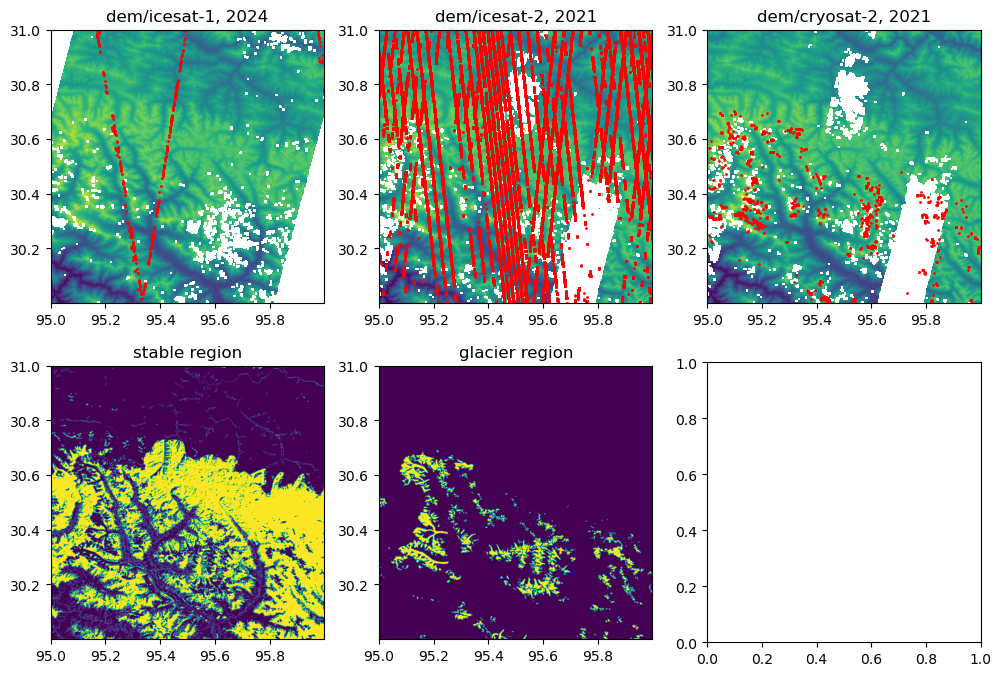

In [4]:
### icesat-1
dem_2004, dem_2004_info = readTiff(path_dem_2004)
mask_stable = img2extent(path_img=path_stable, extent=dem_2004_info['geoextent'], size_target = dem_2004.shape) # read and resize
mask_glacier = img2extent(path_img=path_glacier, extent=dem_2004_info['geoextent'], size_target = dem_2004.shape) # read and resize
isat1_dict = {}
with h5py.File(path_isat1, 'r') as f_read:
    for key in f_read.keys(): isat1_dict[key] = f_read[key][:]
dem_2004[dem_2004<0]=np.nan
fig, ax = plt.subplots(2,3,figsize=(12, 8))
ax[0][0].imshow(dem_2004, extent=dem_2004_info['geoextent'])
ax[0][0].scatter(x=isat1_dict['lon'], y=isat1_dict['lat'], s=1, color='red')
ax[0][0].set_title('dem/icesat-1, 2024')

### icesat-2
dem_2021, dem_2021_info = readTiff(path_dem_2021)
isat2_dict = {}
with h5py.File(path_isat2, 'r') as f_read:
    for key in f_read.keys(): isat2_dict[key] = f_read[key][:]
dem_2021[dem_2021<0]=np.nan
ax[0][1].imshow(dem_2021, extent=dem_2021_info['geoextent'])
ax[0][1].scatter(x=isat2_dict['lon'], y=isat2_dict['lat'], s=1, color='red')
ax[0][1].set_title('dem/icesat-2, 2021')

### cryosat-2
cryo2_dict = {}
with h5py.File(path_cryo2, 'r') as f_read:
    for key in f_read.keys(): cryo2_dict[key] = f_read[key][:]
dem_2021[dem_2021<0]=np.nan
ax[0][2].imshow(dem_2021, extent=dem_2021_info['geoextent']); 
ax[0][2].scatter(x=cryo2_dict['lon'], y=cryo2_dict['lat'], s=1, color='red'); 
ax[0][2].set_title('dem/cryosat-2, 2021')

### stable and glacier mask
ax[1][0].imshow(mask_stable, extent=dem_2004_info['geoextent']); ax[1][0].set_title('stable region')
ax[1][1].imshow(mask_glacier, extent=dem_2004_info['geoextent']); ax[1][1].set_title('glacier region')



### **1. icesat and aster dem**

In [5]:
### select the validation data.
dir_isat1_2004 = 'data/icesat-1/GLAH14-2004/tiles'
dir_isat1_2005 = 'data/icesat-1/GLAH14-2005/tiles'
dir_isat1_2006 = 'data/icesat-1/GLAH14-2006/tiles'
dir_isat1_2007 = 'data/icesat-1/GLAH14-2007/tiles'
dir_isat1_2008 = 'data/icesat-1/GLAH14-2008/tiles'
paths_isat1 = glob(dir_isat1_2004 + '/tile_??_??.h5') + glob(dir_isat1_2005 + '/tile_??_??.h5') + \
            glob(dir_isat1_2006 + '/tile_??_??.h5') + glob(dir_isat1_2007 + '/tile_??_??.h5') + glob(dir_isat1_2008 + '/tile_??_??.h5')
print(len(paths_isat1))
random.seed(10); random.shuffle(paths_isat1)
paths_isat1 = paths_isat1[0:120]
### extract tile_id and year_tile
tiles_id = [path.split('/')[-1].split('.')[0] for path in paths_isat1]
years_tile = [path.split('GLAH14-')[-1][0:4] for path in paths_isat1]
### find the corresponding paths of aster dem, stable image, glacier image.
paths_aster_dem = ['data/aster-stereo/SETP-'+years_tile[i] + '/tiles-dem/' + \
            tiles_id[i].replace('_', '-') + '/dems_mosaic_subs.tif' for i in range(len(tiles_id))]

paths_stable = ['data/land-cover/stable-cover/tiles-2010/' + tiles_id[i] + '.tif' for i in range(len(tiles_id))]
paths_glacier = ['data/land-cover/rgi60/tiles/' + tiles_id[i] + '.tif' for i in range(len(tiles_id))]
paths_srtm = ['data/dem-data/srtm-c/tiles/' + tiles_id[i] + '.tif'  for i in range(len(tiles_id))]



140


In [6]:
isat1_dem_dict = {}
for i in range(len(paths_isat1)):
    if os.path.exists(paths_aster_dem[i]):
        isat1_dem_dict_ = altimeter_dem_cross(path_altimeter=paths_isat1[i], path_aster_dem=paths_aster_dem[i], \
                                                path_srtm_dem=paths_srtm[i], path_stable=paths_stable[i], path_glacier=paths_glacier[i])
    if len(isat1_dem_dict) == 0 and len(isat1_dem_dict_) > 0:
        isat1_dem_dict = isat1_dem_dict_
    elif len(isat1_dem_dict) > 0 and len(isat1_dem_dict_) > 0:
        for key in isat1_dem_dict_.keys():
            isat1_dem_dict[key] = np.concatenate((isat1_dem_dict[key], isat1_dem_dict_[key]), axis=0)
    else: continue
    print(isat1_dem_dict['h'].shape)



(69,)
(611,)
(773,)
(773,)
(831,)
(1176,)
(1185,)
(1186,)
(1221,)
(1221,)
(1305,)
(1374,)
(1595,)
(1611,)
(1787,)
(1838,)
(1889,)
(2007,)
(2248,)
(2419,)
(2475,)
(2507,)
(2535,)
(2571,)
(2592,)
(2674,)
(2674,)
(2682,)
(2777,)
(2834,)
(2924,)
(2926,)
(2935,)
(2944,)
(3115,)
(3115,)
(3115,)
(3235,)
(3237,)
(3568,)
(3573,)
(4264,)
(4317,)
(4335,)
(4571,)
(4602,)
(4826,)
(4898,)
(4913,)
(4913,)
(5190,)
(5228,)
(5229,)
(5229,)
(5452,)
(5488,)
(5552,)
(5582,)
(5582,)
(5642,)
(5702,)
(5849,)
(5897,)
(5937,)
(6000,)
(6133,)
(6341,)
(6356,)
(6371,)
(6371,)
(6373,)
(6375,)
(6391,)
(6434,)
(6711,)
(7031,)
(7080,)
(7129,)
(7198,)
(7250,)
(7487,)
(7724,)
(7736,)
(7748,)
(7764,)
(7850,)
(8064,)
(8515,)
(8522,)
(8529,)
(8536,)
(8536,)
(8577,)
(8638,)
(8892,)
(9146,)
(9156,)
(9301,)
(9433,)
(9436,)
(9495,)
(9501,)
(9861,)
(9972,)
(10123,)
(10348,)
(10445,)
(10494,)
(10500,)
(10500,)
(10802,)
(10838,)
(10859,)
(10903,)
(11260,)
(11284,)
(11502,)
(11504,)
(11565,)
(11565,)


In [7]:
## write out
with open(path_isat1_dem,"wb") as f:
    pickle.dump(isat1_dem_dict, f)



### **2. icesat2 and aster dem**

In [8]:
### select the validation data.
dir_isat2_2018 = 'data/icesat-2/ATL06-2018/tiles'
dir_isat2_2019 = 'data/icesat-2/ATL06-2019/tiles'
dir_isat2_2022 = 'data/icesat-2/ATL06-2022/tiles'
paths_isat2 = glob(dir_isat2_2018 + '/tile_??_??.h5') + \
                          glob(dir_isat2_2019 + '/tile_??_??.h5') + glob(dir_isat2_2022 + '/tile_??_??.h5')
print(len(paths_isat2))
random.seed(10); random.shuffle(paths_isat2)
paths_isat2 = paths_isat2[0:10]
### extract tile_id and year_tile
tiles_id = [path.split('/')[-1].split('.')[0] for path in paths_isat2]
years_tile = [path.split('ATL06-')[-1][0:4] for path in paths_isat2]
### find the corresponding paths of aster dem, stable image, glacier image.
paths_aster_dem = ['data/aster-stereo/SETP-'+years_tile[i] + '/tiles-dem/' + \
            tiles_id[i].replace('_', '-') + '/dems_mosaic_subs.tif' for i in range(len(tiles_id))]

paths_stable = ['data/land-cover/stable-cover/tiles-2010/' + tiles_id[i] + '.tif' for i in range(len(tiles_id))]
paths_glacier = ['data/land-cover/rgi60/tiles/' + tiles_id[i] + '.tif' for i in range(len(tiles_id))]
paths_srtm = ['data/dem-data/srtm-c/tiles/' + tiles_id[i] + '.tif'  for i in range(len(tiles_id))]


81


In [9]:
isat2_dem_dict = {}
for i in range(len(paths_isat2)):
    if os.path.exists(paths_aster_dem[i]):
        isat2_dem_dict_ = altimeter_dem_cross(path_altimeter=paths_isat2[i], path_aster_dem=paths_aster_dem[i], \
                                path_srtm_dem=paths_srtm[i], path_stable=paths_stable[i], path_glacier=paths_glacier[i])
    if len(isat2_dem_dict) == 0 and len(isat2_dem_dict_) > 0:
        isat2_dem_dict = isat2_dem_dict_
    elif len(isat2_dem_dict) > 0 and len(isat2_dem_dict_) > 0:
        for key in isat2_dem_dict_.keys():
            isat2_dem_dict[key] = np.concatenate((isat2_dem_dict[key], isat2_dem_dict_[key]), axis=0)
    else: continue
    print(isat2_dem_dict['h'].shape)



(5689,)
(183236,)
(242360,)
(325663,)
(408966,)
(437200,)
(580419,)
(734696,)
(888973,)
(899669,)


In [10]:
## write out
with open(path_isat2_dem,"wb") as f:
    pickle.dump(isat2_dem_dict, f)


### **2. cryosat2 and aster dem**

In [11]:
### select the validation data.
dir_cryo2_2011 = 'data/cryosat-2/eolis-point-2011/tiles'
dir_cryo2_2014 = 'data/cryosat-2/eolis-point-2014/tiles'
dir_cryo2_2018 = 'data/cryosat-2/eolis-point-2018/tiles'
dir_cryo2_2021 = 'data/cryosat-2/eolis-point-2021/tiles'
paths_cryo2 = glob(dir_cryo2_2011 + '/tile_??_??.h5') + glob(dir_cryo2_2014 + '/tile_??_??.h5') + \
                          glob(dir_cryo2_2018 + '/tile_??_??.h5') + glob(dir_cryo2_2021 + '/tile_??_??.h5')
print(len(paths_cryo2))
random.seed(10); random.shuffle(paths_cryo2)
paths_cryo2 = paths_cryo2[0:20]
### extract tile_id and year_tile
tiles_id = [path.split('/')[-1].split('.')[0] for path in paths_cryo2]
years_tile = [path.split('eolis-point-')[-1][0:4] for path in paths_cryo2]
### find the corresponding paths of aster dem, stable image, glacier image.
paths_aster_dem = ['data/aster-stereo/SETP-'+years_tile[i] + '/tiles-dem/' + \
            tiles_id[i].replace('_', '-') + '/dems_mosaic_subs.tif' for i in range(len(tiles_id))]

paths_stable = ['data/land-cover/stable-cover/tiles-2010/' + tiles_id[i] + '.tif' for i in range(len(tiles_id))]
paths_glacier = ['data/land-cover/rgi60/tiles/' + tiles_id[i] + '.tif' for i in range(len(tiles_id))]
paths_srtm = ['data/dem-data/srtm-c/tiles/' + tiles_id[i] + '.tif'  for i in range(len(tiles_id))]



87


In [12]:
cryo2_dem_dict = {}
for i in range(len(paths_cryo2)):
    if os.path.exists(paths_aster_dem[i]):
        cryo2_dem_dict_ = altimeter_dem_cross(path_altimeter=paths_cryo2[i], path_aster_dem=paths_aster_dem[i], \
                                path_srtm_dem=paths_srtm[i], path_stable=paths_stable[i], path_glacier=paths_glacier[i])
    if len(cryo2_dem_dict) == 0 and len(cryo2_dem_dict_) > 0:
        cryo2_dem_dict = cryo2_dem_dict_
    elif len(cryo2_dem_dict) > 0 and len(cryo2_dem_dict_) > 0:
        for key in cryo2_dem_dict_.keys():
            cryo2_dem_dict[key] = np.concatenate((cryo2_dem_dict[key], cryo2_dem_dict_[key]), axis=0)
    else: continue
    print(cryo2_dem_dict['h'].shape)



(3462,)
(3601,)
(11066,)
(11115,)
(12488,)
(12511,)
(28175,)
(32431,)
(32476,)
(33336,)
(33490,)
(36045,)
(36094,)
(36094,)
(36094,)
(36363,)
(37386,)
(37391,)
(37467,)
(37530,)


In [13]:
## write out
with open(path_cryo2_dem,"wb") as f:
    pickle.dump(cryo2_dem_dict, f)

